In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


K-Means Cluster Analysis (by Stefanie)
-----------------

In [2]:
# Just for inspecting (and not forgetting about potentially useful information from) the whole joined dataset
df_jointdata = pd.read_csv('joint_data.csv')
df_jointdata.head()

,route_id,route_linestring,num_of_waypoint,waypoint_longitude,waypoint_latitude,poi_lat_lgt,poi_longitude,poi_latitude,poi_category,poi_name,distance
0,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",133,13.67734,52.43849,POINT (13.6774745 52.4385208),13.677475,52.438521,viewpoint,Müggeleck,0.000138
1,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",282,13.62759,52.44386,POINT (13.6279051 52.444312),13.627905,52.444312,bench,NaN,0.000551
2,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",288,13.62704,52.44442,POINT (13.6271595 52.4444457),13.627159,52.444446,bench,NaN,0.000122
3,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",288,13.62704,52.44442,POINT (13.6269487 52.4444808),13.626949,52.444481,bench,NaN,0.000110
4,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",292,13.62716,52.44509,POINT (13.6273851 52.4453161),13.627385,52.445316,bench,NaN,0.000319


In [111]:
# Loading extracted poicount data and making it easy to work with
df_poicount = pd.read_csv('category_count_per_route.csv')
df_poicount.fillna(0, inplace = True) # replacing NaN values with 0s, because having counted no poi in fact IS 0
df_poicount = df_poicount.apply(np.int64)
df_poicount.rename(columns={"wp_count": "wp", "poi_count": "poi", "tree_count": "tree", "bench_count": "bench", "bench_count.1": "restaurant", "cafe_count": "cafe", "atm_count": "atm", "convenience_count": "convenience", "bar_count": "bar", "ice_cream_count": "ice_cream", "picnic_table_count": "picnic", "viewpoint_count": "viewpoint", "gallery_count": "gallery", "museum_count": "museum", "nightclub_count": "nightclub", "drinking_water_count": "drinking_water", "historic_count": "historic", "tourist_attraction_count": "tourist_attraction"}, inplace=True)
df_poicount.head()

,route_id,wp,poi,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction
0,3503503,8,14,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2713522,8,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3503504,8,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3568200,8,18,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3573326,9,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0


Cleaning out the noise?
--------------------------------------------------------------------------------------------------------------------------------------

K-Means is noise sensitive. Since our data has a huge variance both along axis 0 and along axis 1, as can be confirmed by looking at the data exploration files in the visualisation folder, there's lot's of noise to be expected.

In our data, we'll define routes as noise, when they pass along an exceptionaly lange number of points of interest. (Yes, our noise is the routes with more information on it than the other routes.)

If we'd keep those very distinct elements while going with the recommended number of clusters (k) from the elbow or the silhouette method, k-Means wouldn't perform well returning one big cluster and some sprinkeled ones for the clusters with very few elements in it each.

On the other hand, if we'd exclude exceptionally point of interest-enriched routes, then the given number if clusters would be distributed more among the more dense data, to the cost of losing the "best" routes from our joined dataset. This seeming to costly, especially since we would later like to integrate more point of interest data and enrich those existing routes more, that's not a good option either.

The solution we adopted here is to keep the noise and at the same time to raise the number of clusters above what elbow or the silhouette method would recommend. This way, we'll get more clusters even in the very dense part of the data while at still including those routes that are very rich in points of interest.

In [4]:
# filtering out any route that pass by more than 500 points of interest             <-- not applied for the reason explained above
#df_poicount = df_poicount.loc[lambda x: x['poi'] < 500]

In [106]:
# Writing the easier to work with df in a new csv file
df_poicount.to_csv(r'poicount.csv', index=False)

In [107]:
# Calculating the percentage of the feature "tree", thus reminding us of what's special about our dataset
print('Trees make out by far the largest amount in our data.', df_poicount['tree'].sum()/df_poicount.iloc[:, 3:].sum().sum()*100, "% of our points of interest is trees.")

Trees make out by far the largest amount in our data. 79.83184053389533 % of our points of interest is trees.


In [108]:
# Reading poicount data in as numpy arrays
poicount = np.genfromtxt('poicount.csv', delimiter=",", usecols=range(3, 19), skip_header=1)

<AxesSubplot:>

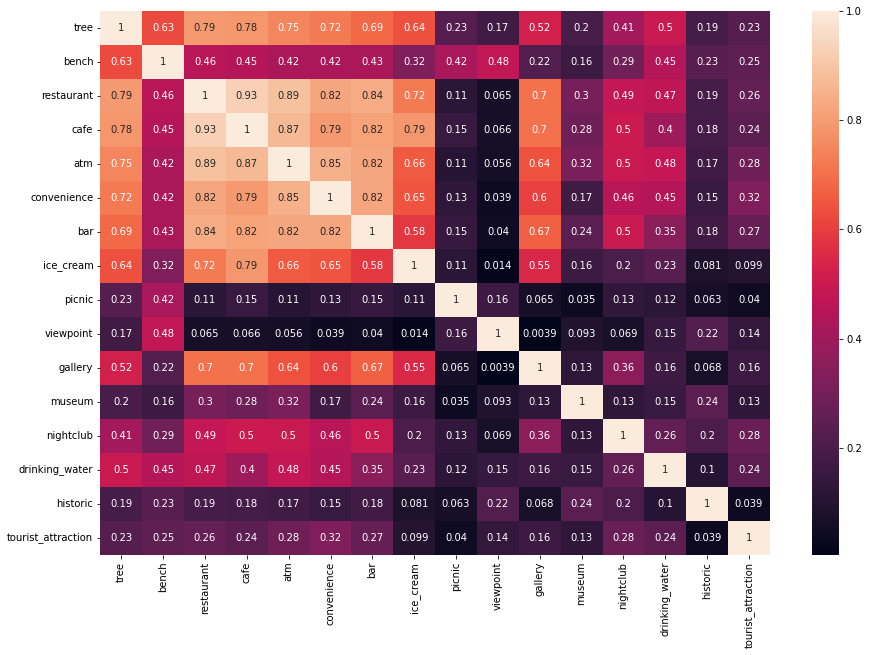

In [8]:
# Getting correlations for all the points of interest (poi)
correlations = df_poicount.iloc[:, 3:].corr()
f,ax=plt.subplots(figsize=(15,10))
sns.heatmap(correlations,annot=True)

Observations:

We can see that restaurants, cafes, convenience shops, atms, bars, ice cream shops, galleries, and trees often come along (meaning being on the same route) with each other. It can be suspected that these togeter will form a cluster. (Sometimes, there's also nightclubs and drinking water on these routes.)

Viewpoints and picnic tables don't correlate with most of the other features, not even with each other, which is surprising. But sometimes they come along with benches, which make sense. 

Trees, surprisingly, don't seem to join the nature routes that often, but tend to be on those routes with shops and cafes. 

Tourist attractions and historic sides don't show a clear correlation and seem to be scattered among the other categories (we only have small amounts of those in our dataset though). 

Nightclubs seem to go best with bars, cafes and atms, but no clear correlation here.

Elbow method for finding the optimal k
-----

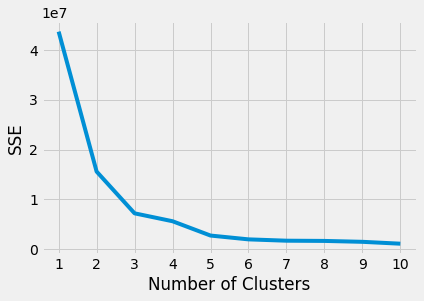

In [9]:
# Increasing k by 1 with every step and store the SSE in a list
kmeans_kwargs = {"init": "random", "n_init": 50, "max_iter": 500}

# Writing the SSE values for each k into a list
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(poicount)
    sse.append(kmeans.inertia_)

# Graphically finding the "elbow", where the SSE and the number of clusters are in reasonable trade-off to each other
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

2 or 3 clusters will yield the best separation.

In [10]:
# Using the Python package "kneed" to identify the elbow point programmatically
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

3

3 clusters are recommended.

Silhouette method for finding the optimal k
----------------------

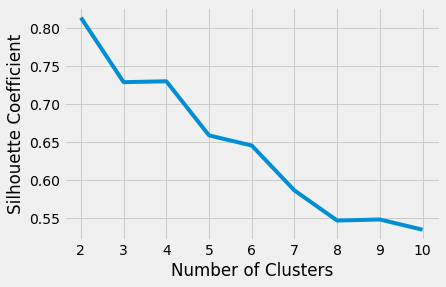

In [11]:
# Making a list for the silhouette coefficients for each k, starting at 2
silhouette_coefficients = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(poicount)
    score = silhouette_score(poicount, kmeans.labels_)
    silhouette_coefficients.append(score)

# Plotting the average silhouette scores for each k
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

This would speak for asuming only 2 clusters. In fact, visualisation shows that most of the data is very densely centered, but the silhouette can only sensefully start at two clusters. By experimenting with the data (not shown here) we found out, that when we'd reduce it to two clusters, then the biggest cluster would "eat" the second biggest cluster, which is a gross loss in information, especially since the biggest cluster is the biggest by far. So, we'll percede with at least 3 clusters.

For reasons explained in the above section "Cleaning out the noise?", we're not taking the advised k from the elbow or the silhouette method, but we'll add some more clusters.

Implementing k-Means
------------------------------------------------------------------------------------------------------------------------------------

In [12]:
# Initialising the KMeans class, running 50 times with a max of 500 interations each
kmeans = KMeans(init="random", n_clusters=8, n_init=50, max_iter=500)

# Applying the KMeans class to our data: it returns that result with the smallest SSE
kmeans.fit(poicount)

# Getting lables for later mapping these to our dataframe
label = kmeans.labels_

In [13]:
# Looking at the lowest SSE value
kmeans.inertia_

1570020.9677248397

That high number is to be expected, because we have only 430 samples lost in 16 dimensions.

In [14]:
# Number of iterations required to converge
print(kmeans.n_iter_, 'iterations')

34 iterations


In [15]:
# Cluster assignments
kmeans.labels_[:20] #looking at the first 20

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 2, 5, 5, 5, 0, 2, 2])

In [16]:
# Checking how many times each label appears
unique, counts = np.unique(kmeans.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 51, 1: 14, 2: 76, 3: 3, 4: 14, 5: 203, 6: 35, 7: 34}

One route is the most frequent. By raising k, we found some subclusters within that very dense centre.

In [17]:
# Assigning the found cluster centres to each feature
cluster_centers = pd.DataFrame(data=kmeans.cluster_centers_, columns = [df_poicount.columns[3:]])
cluster_centers

,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction
0,158.686275,27.196078,7.843137,4.509804,1.803922,1.196078,1.843137,0.588235,0.627451,0.215686,0.333333,0.607843,0.352941,0.137255,0.176471,1.176471e-01
1,689.000000,63.500000,23.500000,12.785714,5.285714,4.642857,4.928571,2.000000,1.571429,0.500000,0.785714,0.500000,0.357143,0.500000,0.142857,1.387779e-17
2,65.315789,17.250000,3.131579,1.723684,0.697368,0.486842,0.513158,0.157895,0.065789,0.144737,0.210526,0.131579,0.144737,0.078947,0.078947,6.578947e-02
3,2304.000000,149.333333,90.333333,57.666667,28.333333,31.333333,22.333333,9.000000,1.666667,0.666667,6.000000,0.666667,2.333333,2.333333,0.666667,1.000000e+00
4,1212.357143,107.285714,37.857143,22.928571,9.500000,4.785714,6.000000,1.642857,1.642857,1.285714,1.571429,1.071429,1.642857,1.428571,0.357143,2.142857e-01
5,6.901478,8.147783,1.699507,0.788177,0.290640,0.128079,0.142857,0.083744,0.359606,0.320197,0.049261,0.093596,0.019704,0.064039,0.039409,4.433498e-02
6,433.457143,57.857143,15.600000,8.685714,3.571429,3.828571,2.828571,1.428571,0.457143,0.885714,0.600000,0.571429,0.285714,0.342857,0.228571,2.000000e-01
7,281.470588,44.264706,10.705882,6.823529,2.500000,1.794118,1.794118,0.705882,0.441176,0.588235,0.617647,0.500000,0.823529,0.470588,0.264706,2.058824e-01


In [22]:
# Comment on the cluster dataframe (so it stays correct with each update)
max_value = max(dict(zip(unique, counts)).values())
max_keys = [k for k, v in dict(zip(unique, counts)).items() if v == max_value]
print('Obviously, "cluster', max_keys, '" stands out for its high procimity to 0! Its the largest cluster and closest to the dense centre. It contains routes that pass by only few poi.')

Obviously, "cluster [5] " stands out for its high procimity to 0! Its the largest cluster and closest to the dense centre. It contains routes that pass by only few poi.


It seems, that k-Means clusters the routes regarding their number of points of interest (poi) they pass by. It wasn't intended to cluster on the number of poi, but rather on the TYPES of features (poi) along the routes. Nonetheless, it seems that the clusters found indicate more interesting and less interesting routes, instead of finding the "cafe and benches" routes, the "trees and nature" routes, the "bars, nightclubs and atms" routes, as we had originally intended to find when we first had started the project.

Because in our data the routes have a very huge variance regarding their number of points of interest they pass by (also see the visualisations in the visualisations folder), we tested if a row wise standardisation of the values would help that.

In [94]:
# Displaying information on the variance in number of points of interest found for each route (consider the std)
df_poicount['poi'].describe()

count     430.000000
mean      211.869767
std       369.018893
min         1.000000
25%        14.000000
50%        62.000000
75%       256.250000
max      3171.000000
Name: poi, dtype: float64

Standardising on axis = 0 (not shown here) did even seem to make it worse (reasons are explained in that [blog post](https://www.r-bloggers.com/2015/05/centering-and-standardizing-dont-confuse-your-rows-with-your-columns/)).

As this notebook is supposed to log a process and be explanatory, we stick with the absolute values here for now, until a few blocks down, we can show what's the problem with it.

In [23]:
# Mapping our labels into our dataframe (each route gets a cluster label)
df_poicount_cluster = pd.concat([df_poicount, pd.DataFrame({'cluster':label})], join='inner', axis=1)
df_poicount_cluster.head()

,route_id,wp,poi,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction,cluster
0,3503503,8,14,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
1,2713522,8,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
2,3503504,8,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
3,3568200,8,18,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
4,3573326,9,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,5


In [24]:
# Writing the enhanced dataframe into a new csv file.
df_poicount_cluster.to_csv('clustered_routes.csv')

In [25]:
# Inspecting clusters
df_clusterinspect = df_poicount_cluster[df_poicount_cluster['cluster'] == 6] # substituting the cluster we're interested in
df_clusterinspect


,route_id,wp,poi,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction,cluster
81,2844573,66,451,416,3,12,8,2,6,2,1,0,0,0,0,1,0,0,0,6
82,2845688,67,448,411,5,12,8,2,6,2,1,0,0,0,0,1,0,0,0,6
84,2844727,67,453,418,3,12,8,2,6,2,1,0,0,0,0,1,0,0,0,6
91,2324442,70,491,469,7,4,4,1,4,2,0,0,0,0,0,0,0,0,0,6
118,758250,87,532,416,30,34,13,13,13,4,6,0,0,1,0,0,2,0,0,6
155,3665707,135,563,441,57,30,18,2,2,6,5,0,0,0,1,0,1,0,0,6
164,3665708,140,474,372,58,17,16,3,1,5,1,0,0,0,1,0,0,0,0,6
171,2882227,148,455,412,40,2,0,1,0,0,0,0,0,0,0,0,0,0,0,6
177,933359,156,672,455,77,57,29,15,11,9,6,4,0,6,1,2,0,0,0,6
194,3504240,180,430,382,24,7,5,1,6,5,0,0,0,0,0,0,0,0,0,6


In [143]:
# Printing some impressions from inspecting the clusters
print('Observations from inspecting the clusters:')
for ele in np.unique(label):
    print('Cluster', np.unique(label)[ele], ': All routes have similar amount of trees: mean around', 
    df_poicount_cluster[df_poicount_cluster['cluster'] == np.unique(label)[ele]]['tree'].mean())

Observations from inspecting the clusters:
Cluster 0 : All routes have similar amount of trees: mean around 3.06391258538721
Cluster 1 : All routes have similar amount of trees: mean around 4.156928643798609
Cluster 2 : All routes have similar amount of trees: mean around 0.19315411658656195
Cluster 3 : All routes have similar amount of trees: mean around 0.7641671360610026
Cluster 4 : All routes have similar amount of trees: mean around -0.23159527664257767
Cluster 5 : All routes have similar amount of trees: mean around 1.5874211980419677
Cluster 6 : All routes have similar amount of trees: mean around -0.5007620535012625
Cluster 7 : All routes have similar amount of trees: mean around 6.749356949575841


The number of trees seem the be the only real distinction in the data, while all the 0s in the other 15 columns, tear the whole data down to a single, dense centre.

This is also affirmed by the following Principal Component Analysis:

Principal Component Analysis and plotting in 2D
------------------------------------------------------------

In [197]:
# Principal Component Analysis
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(df_poistand)     # substitude df_poicount if needed
pca_df = pd.DataFrame(data=principal_comp,columns=['pca1','pca2'])
pca_df = pd.concat([pca_df,pd.DataFrame({'cluster':label})],axis=1)
pca_df.head()

,pca1,pca2,cluster
0,-460507.851321,-498.848762,3
1,329473.145787,-430.465510,3
2,-460508.851147,-500.401579,3
3,-525204.851190,-503.512149,3
4,-530330.850696,-507.998120,3


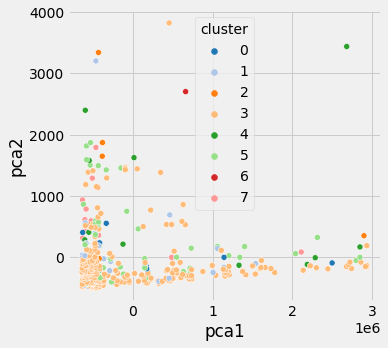

In [198]:
# Scatterplot of our clusters, reduced to two dimensions
plt.figure(figsize=(5,5))
ax= sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=pca_df, palette='tab20')
plt.show()

The clusters don't look spheric and (even worse) they are overlapping, caused by pretty large variances.

Variances among features (PCA components)
-----

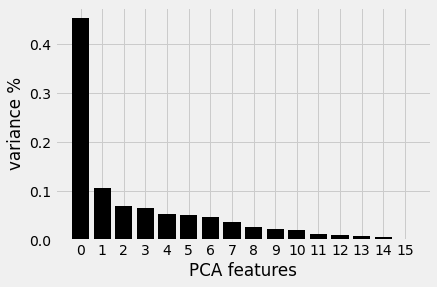

In [199]:
# Standardising and plotting the variances of the features
X_std = StandardScaler().fit_transform(df_poistand.iloc[:, 3:])  # substitude df_poicount if needed
pca = PCA(n_components=16)

principalComponents = pca.fit_transform(X_std)
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)


PCA_components = pd.DataFrame(principalComponents)

The data is as such, that it would even be admissible to reduce it to one dimension (which we know is the number of trees).

Text(0, 0.5, 'PCA 2')

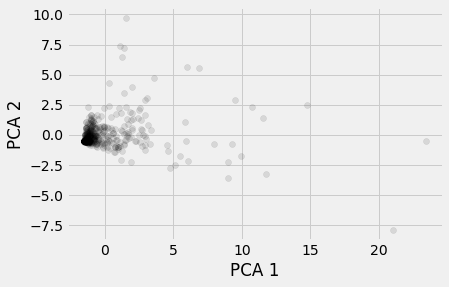

In [200]:
# Plotting the most influencial two features
plt.scatter(PCA_components[0], PCA_components[1], alpha= 0.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

Even the two most influencial features would map most datapoints into one dense centre.

Standardisation on axis = 1
-------

In [115]:
# Loading extracted poicount data and making it easy to work with
df_poicount = pd.read_csv('category_count_per_route.csv')
df_poicount.fillna(0, inplace = True) # replacing NaN values with 0s, because having counted no poi in fact IS 0
df_poicount = df_poicount.apply(np.int64)
df_poicount.rename(columns={"wp_count": "wp", "poi_count": "poi", "tree_count": "tree", "bench_count": "bench", "bench_count.1": "restaurant", "cafe_count": "cafe", "atm_count": "atm", "convenience_count": "convenience", "bar_count": "bar", "ice_cream_count": "ice_cream", "picnic_table_count": "picnic", "viewpoint_count": "viewpoint", "gallery_count": "gallery", "museum_count": "museum", "nightclub_count": "nightclub", "drinking_water_count": "drinking_water", "historic_count": "historic", "tourist_attraction_count": "tourist_attraction"}, inplace=True)

In [116]:
# Renaming, so df_poicount get's not messed with # get's messed with anyway, I cannot find why...
df_poistand = df_poicount

# Getting the columns we want to standardise
df_columns = df_poistand[['tree', 'bench', 'restaurant', 'cafe', 'atm',
       'convenience', 'bar', 'ice_cream', 'picnic', 'viewpoint', 'gallery',
       'museum', 'nightclub', 'drinking_water', 'historic',
       'tourist_attraction']]

# Standardising the values for each variable
df_poistand[['tree', 'bench', 'restaurant', 'cafe', 'atm',
       'convenience', 'bar', 'ice_cream', 'picnic', 'viewpoint', 'gallery',
       'museum', 'nightclub', 'drinking_water', 'historic',
       'tourist_attraction']] = (df_columns-df_columns.mean())/df_columns.std()

df_poistand.head()

,route_id,wp,poi,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction
0,3503503,8,14,-0.490473,-0.661214,-0.528217,-0.478947,-0.430885,-0.362437,-0.406891,-0.367831,-0.36249,-0.379029,-0.294444,-0.3018,-0.291943,-0.348438,-0.264851,-0.271723
1,2713522,8,2,-0.534734,-0.608174,-0.528217,-0.478947,-0.430885,-0.362437,-0.406891,-0.367831,-0.36249,-0.379029,-0.294444,-0.3018,-0.291943,-0.348438,-0.264851,-0.271723
2,3503504,8,9,-0.506281,-0.661214,-0.528217,-0.478947,-0.430885,-0.362437,-0.406891,-0.367831,-0.36249,-0.379029,-0.294444,-0.3018,-0.291943,-0.348438,-0.264851,-0.271723
3,3568200,8,18,-0.477827,-0.661214,-0.528217,-0.478947,-0.430885,-0.362437,-0.406891,-0.367831,-0.36249,-0.379029,-0.294444,-0.3018,-0.291943,-0.348438,-0.264851,-0.271723
4,3573326,9,2,-0.534734,-0.661214,-0.377947,-0.478947,-0.430885,-0.362437,-0.406891,-0.367831,-0.36249,-0.379029,-0.294444,-0.3018,-0.291943,-0.348438,-0.264851,-0.271723


In [120]:
# Writing the standardised df in a new csv file
df_poistand.to_csv(r'poistand.csv', index=False)

In [121]:
# Reading poistand data in as numpy arrays
poistand = np.genfromtxt('poistand.csv', delimiter=",", usecols=range(3, 19), skip_header=1)

Running k-Means on standardised features

In [122]:
# Initialising the KMeans class, running 50 times with a max of 500 interations each
kmeans = KMeans(init="random", n_clusters=8, n_init=50, max_iter=500)

# Applying the KMeans class to our data: it returns that result with the smallest SSE
kmeans.fit(poistand)

# Getting lables for later mapping these to our dataframe
label = kmeans.labels_

In [123]:
# Checking how many times each label appears
unique, counts = np.unique(kmeans.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 11, 1: 27, 2: 9, 3: 287, 4: 18, 5: 66, 6: 1, 7: 11}

In [182]:
# Assigning the found cluster centres to each feature
cluster_centers = pd.DataFrame(data=kmeans.cluster_centers_, columns = [df_poicount.columns[3:]])
cluster_centers

,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction
0,0.132917,0.452631,0.270947,0.278610,0.046273,-0.102474,0.444154,0.109192,-0.065735,0.788339,-0.125178,2.720737,0.246374,-0.348438,4.383553,-0.006176
1,0.019699,0.437897,0.022774,0.111867,-0.090689,0.082389,0.011567,0.159671,0.181562,-0.013187,-0.087563,0.015981,0.366000,0.156035,-0.178769,3.082044
2,1.908401,3.994540,0.565416,0.526319,0.152308,0.082389,0.131126,0.131908,2.901821,3.023301,-0.191004,0.294040,-0.028766,1.921689,0.509883,0.377393
3,-0.401687,-0.367368,-0.396273,-0.374005,-0.335786,-0.312618,-0.364150,-0.305146,-0.115108,-0.107134,-0.255519,-0.189691,-0.258931,-0.253520,-0.175770,-0.271723
4,0.886183,0.586705,1.821842,1.538198,1.377014,1.273886,1.135425,1.547836,-0.135802,0.005105,1.257160,0.949465,0.366000,0.881214,0.251638,-0.271723
5,0.553061,0.265382,0.303961,0.226302,0.233160,0.226813,0.395243,0.245485,-0.102829,-0.124603,0.199248,-0.123048,0.336093,0.193297,-0.159205,-0.271723
6,6.430046,1.964277,7.586375,5.711373,8.754405,11.647858,9.277416,1.880995,-0.362490,1.596517,6.222293,1.843226,6.813835,6.461943,2.059351,8.491347
7,3.384661,2.058303,4.055025,4.380238,4.364552,3.485017,3.848335,3.175774,1.121288,0.159756,3.344773,0.965715,2.399640,1.818501,0.580313,0.524920


From eye inspection, those clusters don't look so homogenously grouped around trees anymore.

In [185]:
# Labelling df_poicoint 

# Loading extracted poicount data again, because for some reason it got messed with a few cells above
df_poicount = pd.read_csv('category_count_per_route.csv')
df_poicount.fillna(0, inplace = True) # replacing NaN values with 0s, because having counted no poi in fact IS 0
df_poicount = df_poicount.apply(np.int64)
df_poicount.rename(columns={"wp_count": "wp", "poi_count": "poi", "tree_count": "tree", "bench_count": "bench", "bench_count.1": "restaurant", "cafe_count": "cafe", "atm_count": "atm", "convenience_count": "convenience", "bar_count": "bar", "ice_cream_count": "ice_cream", "picnic_table_count": "picnic", "viewpoint_count": "viewpoint", "gallery_count": "gallery", "museum_count": "museum", "nightclub_count": "nightclub", "drinking_water_count": "drinking_water", "historic_count": "historic", "tourist_attraction_count": "tourist_attraction"}, inplace=True)

# Mapping our labels into our dataframe (each route gets a cluster label)
df_poistand_cluster = df_poicount.join(pd.DataFrame({'cluster':label}), how='left')
df_poistand_cluster.head()

,route_id,wp,poi,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction,cluster
0,3503503,8,14,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
1,2713522,8,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
2,3503504,8,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
3,3568200,8,18,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
4,3573326,9,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [186]:
# Inspecting clusters on counts --> it's not very useful to look at absolute numbers though
df_clusterinspect = df_poistand_cluster[df_poistand_cluster['cluster'] == 0] # substituting the cluster we're interested in
df_clusterinspect

,route_id,wp,poi,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction,cluster
95,3458593,72,196,130,1,25,18,1,0,15,2,0,0,0,0,2,0,2,0,0
150,546890,131,61,39,17,2,0,0,0,1,0,0,0,0,0,0,0,2,0,0
162,3617793,140,135,57,29,18,18,3,3,3,1,0,0,1,0,0,0,2,0,0
203,2873677,196,374,344,18,0,2,0,0,0,0,2,0,0,6,0,0,2,0,0
210,2868322,210,194,134,30,2,4,6,0,6,0,0,0,0,12,0,0,0,0,0
260,1899411,311,202,123,51,11,4,3,2,0,1,0,1,0,4,0,0,1,1,0
284,3562709,371,178,121,6,23,10,3,1,1,1,0,0,1,5,2,0,4,0,0
348,3457537,575,621,448,152,7,1,0,0,1,0,1,6,0,2,0,0,3,0,0
350,3457535,587,576,405,149,8,1,0,1,1,0,1,6,0,2,0,0,2,0,0
371,3667927,919,171,150,9,5,4,0,0,0,1,0,0,0,0,0,0,2,0,0


In [187]:
# Labelling df_poistand 
df_poistand_cluster = pd.concat([df_poistand, pd.DataFrame({'cluster':label})], join='inner', axis=1)
df_poistand_cluster.head()

,route_id,wp,poi,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction,cluster
0,3503503,8,14,-0.490473,-0.661214,-0.528217,-0.478947,-0.430885,-0.362437,-0.406891,-0.367831,-0.36249,-0.379029,-0.294444,-0.3018,-0.291943,-0.348438,-0.264851,-0.271723,3
1,2713522,8,2,-0.534734,-0.608174,-0.528217,-0.478947,-0.430885,-0.362437,-0.406891,-0.367831,-0.36249,-0.379029,-0.294444,-0.3018,-0.291943,-0.348438,-0.264851,-0.271723,3
2,3503504,8,9,-0.506281,-0.661214,-0.528217,-0.478947,-0.430885,-0.362437,-0.406891,-0.367831,-0.36249,-0.379029,-0.294444,-0.3018,-0.291943,-0.348438,-0.264851,-0.271723,3
3,3568200,8,18,-0.477827,-0.661214,-0.528217,-0.478947,-0.430885,-0.362437,-0.406891,-0.367831,-0.36249,-0.379029,-0.294444,-0.3018,-0.291943,-0.348438,-0.264851,-0.271723,3
4,3573326,9,2,-0.534734,-0.661214,-0.377947,-0.478947,-0.430885,-0.362437,-0.406891,-0.367831,-0.36249,-0.379029,-0.294444,-0.3018,-0.291943,-0.348438,-0.264851,-0.271723,3


In [195]:
# Inspecting clusters on standardised data
df_poistand_cluster[df_poistand_cluster['cluster'] == 7].iloc[:, 3:-1].mean() # substituting the cluster we're interested in

tree                  3.384661
bench                 2.058303
restaurant            4.055025
cafe                  4.380238
atm                   4.364552
convenience           3.485017
bar                   3.848335
ice_cream             3.175774
picnic                1.121288
viewpoint             0.159756
gallery               3.344773
museum                0.965715
nightclub             2.399640
drinking_water        1.818501
historic              0.580313
tourist_attraction    0.524920
dtype: float64

Observations from inspecting the clusters
-----
(may vary, since k-Means is non-deterministic)

legend: exceptionally = more than 1.0 std, high numbers = more than 0.5 std

-------------------------------------------------------------------------------------------------------------

0: Routes with exceptionally many historic sites and museums and high numbers of benches and viewpoints 

1: Routes with exceptionally many tourist_attractions

2: Routes with exceptionally many trees, benches, picnic tables, drinking water and viewpoints and high numbers of restaurants, cafes and historic sites

3: Routes with nothing special (below average in any category, but never less than -0.5 std)

4: Routes with exceptionally many restaurants, cafes, atms, convenience shops, bars, ice cream shops and gallaries and high numbers of trees, benches, museums and drinking water

5: Routes with high numbers of trees

6: Routes with exceptionally many trees, benches, restaurants, cafes, atms, convenience shops, bars, ice cream shops, viewpoints, galleries, museums, night clubs, drinking water, historic sides and tourist attractions

7: Routes with exceptionally many trees, benches, restaurants, cafes, atms, convenience shops, bars, ice cream shops, picnic tables, galleries, night clubs and drinking water and high numbers of museums, historic sides and tourist attractions

-------------------------------------------------------------------------------------------------------------

The clustering yields too many clusters, so I will re-run it with less clusters.